In [1]:
import matplotlib.pyplot as plt #Visulization
from matplotlib import rc # 한글 깨져서
import seaborn as sns #Visulization
import pandas as pd
import numpy as np

import scipy as sp
import scipy.stats

import datetime as dt
from dateutil.relativedelta import relativedelta

import tensorflow as tf

# tf.set_random_seed(777)
rc('font', family="Malgun Gothic")

In [2]:
mean_of_month = pd.read_csv("mean_of_month_1.csv")

In [3]:
yyyymm_1 = '200801'
yyyymm_2 = '201812'

MONTH = relativedelta(months=+1)

fmt = '%Y%m'
date_1 = dt.datetime.strptime(yyyymm_1, fmt).date()
date_2 = dt.datetime.strptime(yyyymm_2, fmt).date()

yyyymm = []
while date_1 <= date_2:
    yyyymm.append(date_1.strftime('%Y')+date_1.strftime('%m'))
    date_1 += MONTH

In [4]:
mean_of_month['date'] = yyyymm
mean_of_month['yyyy'] = mean_of_month['date'].map(lambda x : x[0:4])
mean_of_month['mm'] = mean_of_month['date'].map(lambda x : x[4:6])

In [5]:
x_t = mean_of_month['kgPrice'][4:]
x_t1 = mean_of_month['kgPrice'][3:-1]
x_t2 = mean_of_month['kgPrice'][2:-2]
x_t3 = mean_of_month['kgPrice'][1:-3]
x_t4 = mean_of_month['kgPrice'][:-4]

xi_t  = np.log(x_t.values  / x_t1.values)
xi_t1 = np.log(x_t1.values / x_t2.values)
xi_t2 = np.log(x_t2.values / x_t3.values)
xi_t3 = np.log(x_t3.values / x_t4.values)

x_train = np.c_[ xi_t1[:-38], xi_t2[:-38], xi_t3[:-38] ]
y_train = xi_t[:-38].reshape(-1,1)
x_test = np.c_[ xi_t1[90:], xi_t2[90:], xi_t3[90:] ]
y_test = xi_t[90:].reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(90, 3)
(90, 1)
(38, 3)
(38, 1)


In [6]:
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.random_normal([x_train.shape[1], 10]))
b1 = tf.Variable(tf.zeros([10]))
H1 = tf.nn.relu(tf.matmul(X, W1)+b1)

W2 = tf.Variable(tf.random_normal([10, 1]))
b2 = tf.Variable(tf.zeros([1]))
model = tf.matmul(H1, W2) + b2

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
cost = tf.reduce_mean(tf.square(model - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(cost)

Instructions for updating:
Use tf.cast instead.


In [8]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for step in range(3000):
        _, cost_val = sess.run([train_op, cost], feed_dict={X: x_train, Y: y_train})
        if step % 1000 == 0: print("[step: {}	loss: {}]".format(step, cost_val))
    # 학습결과 확인
    predict = sess.run(model, feed_dict={X: x_test})
#     print("Y:", sess.run(model, feed_dict={X:x_test }))

[step: 0	loss: 0.6868658065795898]
[step: 1000	loss: 0.0507010892033577]
[step: 2000	loss: 0.0404764860868454]


In [9]:
compare_value = np.c_[y_test, predict]

# numppy array에 컬럼이름 주기
compare_value = {'실제값':compare_value[:,0], '예측값':compare_value[:,1]}

# Dataframe으로 만들기
compare_value = pd.DataFrame(compare_value)

In [10]:
compare_value['실제값_비율'] = -1
compare_value['예측값_비율'] = -1
compare_value['맞았니'] = ''

In [11]:
for i in range(len(compare_value)):
    if(compare_value.iloc[i,0] < 0):
        compare_value.iloc[i,2] = 0
    else: compare_value.iloc[i,2] = 1
    if(compare_value.iloc[i,1] < 0):
        compare_value.iloc[i,3] = 0
    else: compare_value.iloc[i,3] = 1

In [12]:
for i in range(len(compare_value)):
    if(compare_value.iloc[i,2] == compare_value.iloc[i,3]):
        compare_value.iloc[i,4] = 1
    else:
        compare_value.iloc[i,4] = 0

In [13]:
compare_value.iloc[:-1,4].sum() / (x_test.shape[0] - 1)

0.7297297297297297

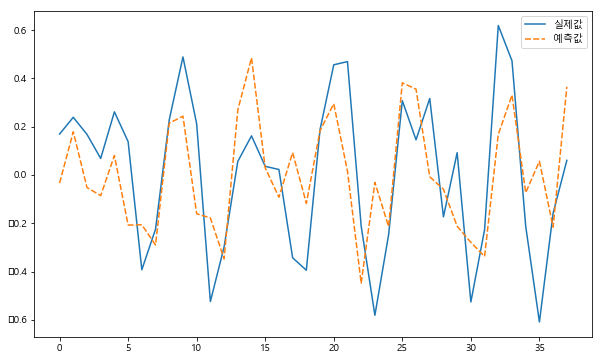

In [14]:
plt.figure(num=None, figsize=(10, 6))
sns.lineplot(data=compare_value.iloc[:,[0,1]])